In [7]:
using DelaySSAToolkit,Pkg
using Catalyst
using Statistics
using Test
using BenchmarkTools
using DataFrames

A chain of delay reactions
$0 \rightarrow A_1, \rightarrow A_2$, ..., $\rightarrow A_N \rightarrow 0$ with time delay = 1 for each cascade delay, N is the length of the delay reaction chain

In [8]:
rn = @reaction_network begin
    5, 0 --> A1
end;

In [9]:
delay_trigger_affect! = []
chain_len = 10
delay_trigger_affect! = function (integrator, rng)
    append!(integrator.de_chan[1], 1.)
end;

In [10]:
u0 = zeros(chain_len)
de_chan0 = []
for _ in 1:chain_len
    push!(de_chan0, [])
end
tspan = (0.,50.)
delay_complete_affect! = []
for i in 1:chain_len-1
    push!(delay_complete_affect!, function (integrator, rng)
        integrator.u[i] -= 1 # A_prev minus 1
        integrator.u[i+1] += 1 # A plus 1
        append!(integrator.de_chan[i+1], 1.) # add to the delay channel
    end
    )
end
push!(delay_complete_affect!, function (integrator, rng)
    integrator.u[chain_len] -= 1 # A_prev minus 1
end);

In [11]:
delay_trigger = Dict(Pair(1, delay_trigger_affect!))
delay_complete = Dict(i=>delay_complete_affect![i] for i in 1:chain_len)
delay_interrupt = Dict()
delayjumpset = DelayJumpSet(delay_trigger, delay_complete, delay_interrupt)
jumpsys = convert(JumpSystem, rn, combinatoric_ratelaws = false)
dprob = DiscreteProblem(jumpsys, u0, tspan);

In [12]:
medianlist=[]
algo_list =[DelayDirect(),DelayRejection(),DelayMNRM(),DelayDirectCR()]
for algo in algo_list
    djprob = DelayJumpProblem(jumpsys,dprob,algo,delayjumpset, de_chan0, save_positions=(false,false))
    bm = @benchmark solve($djprob, SSAStepper())
    push!(medianlist,copy(median(bm).time/1e9))
end;

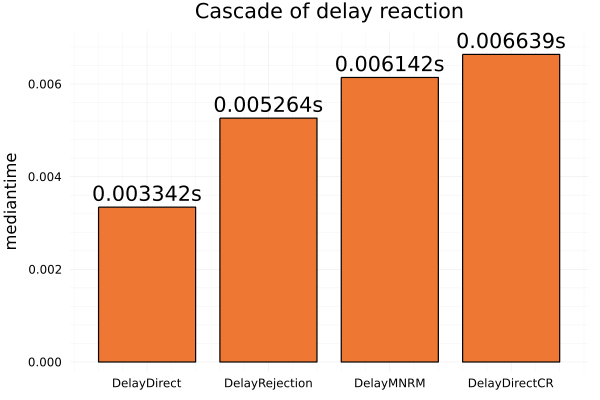

In [17]:
using Plots; theme(:vibrant)
medianvalue=[string(round(mt,digits=6),"s") for mt in medianlist]
algo_name = ["DelayDirect","DelayRejection","DelayMNRM","DelayDirectCR"]
bar(algo_name,medianlist,legend=:false,title="Cascade of delay reaction",ylabel="mediantime")
scatter!(algo_name, 0.0003 .+ medianlist , markeralpha=0, series_annotations=medianvalue)

In [ ]:
versioninfo()

In [ ]:
Pkg.status()